In [7]:
# libraries used in this notebook
import pandas as pd
import numpy as np
import pycountry
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet
import pickle

In [8]:
df=pd.read_csv('remittances_final.csv')
df.head()

,Country Name,Country Code,Year,GDP,Remittance,%Remittance,Total Disasters,Total Deaths,Total Affected
0,Afghanistan,AFG,2000,1.401559e+10,3.620895e+08,2.011777,5,594.0,2868289.0
1,Afghanistan,AFG,2001,1.401559e+10,3.620895e+08,2.011777,6,576.0,490756.0
2,Afghanistan,AFG,2002,3.825701e+09,3.620895e+08,2.011777,16,4265.0,1743975.0
3,Afghanistan,AFG,2003,4.520947e+09,3.620895e+08,2.011777,9,228.0,576876.0
4,Afghanistan,AFG,2004,5.224897e+09,3.620895e+08,2.011777,3,109.0,5540.0


In [9]:
df.isna().sum()

Country Name       0
Country Code       0
Year               0
GDP                0
Remittance         0
%Remittance        0
Total Disasters    0
Total Deaths       0
Total Affected     0
dtype: int64

In [10]:
df.corr()

,Year,GDP,Remittance,%Remittance,Total Disasters,Total Deaths,Total Affected
Year,1.000000,0.066039,0.154565,0.054328,-0.031741,-0.023250,-0.018574
GDP,0.066039,1.000000,0.275965,-0.128224,0.587058,0.039335,0.179659
Remittance,0.154565,0.275965,1.000000,0.053370,0.436755,0.052242,0.283695
%Remittance,0.054328,-0.128224,0.053370,1.000000,-0.086004,-0.007244,-0.029646
Total Disasters,-0.031741,0.587058,0.436755,-0.086004,1.000000,0.166300,0.441281
Total Deaths,-0.023250,0.039335,0.052242,-0.007244,0.166300,1.000000,0.103742
Total Affected,-0.018574,0.179659,0.283695,-0.029646,0.441281,0.103742,1.000000


In [11]:
df.Remittance.mean()

2246879685.492322

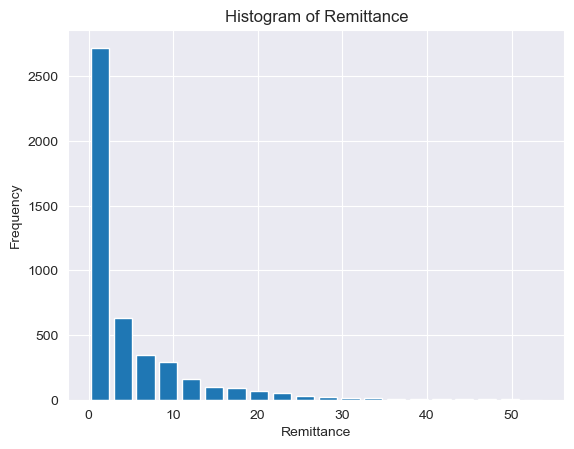

In [12]:
plt.hist(df['%Remittance'], bins=20, rwidth=0.8)
plt.xlabel('Remittance')
plt.ylabel('Frequency')
plt.title('Histogram of Remittance')
plt.show()

In [13]:
df['%Remittance'].describe()

count    4554.000000
mean        4.359808
std         6.467994
min         0.000000
25%         0.275560
50%         1.658234
75%         5.768152
max        53.826395
Name: %Remittance, dtype: float64

In [14]:
df.shape

(4554, 9)

In [15]:
df.head(5)

,Country Name,Country Code,Year,GDP,Remittance,%Remittance,Total Disasters,Total Deaths,Total Affected
0,Afghanistan,AFG,2000,1.401559e+10,3.620895e+08,2.011777,5,594.0,2868289.0
1,Afghanistan,AFG,2001,1.401559e+10,3.620895e+08,2.011777,6,576.0,490756.0
2,Afghanistan,AFG,2002,3.825701e+09,3.620895e+08,2.011777,16,4265.0,1743975.0
3,Afghanistan,AFG,2003,4.520947e+09,3.620895e+08,2.011777,9,228.0,576876.0
4,Afghanistan,AFG,2004,5.224897e+09,3.620895e+08,2.011777,3,109.0,5540.0


## Model Selection and Training

### Linear Regression

In [16]:
#define target variable and features
y = df['Remittance']
X = df[['Total Deaths','Total Affected','Country Name','Year','GDP','Total Disasters']]

In [17]:
numerical_cols = ['Total Deaths', 'Total Affected', 'Year', 'GDP','Total Disasters']
categorical_cols = ['Country Name']

In [18]:
# Initialize OneHotEncoder and StandardScaler
encoder = OneHotEncoder(sparse=False)
scaler = StandardScaler()

In [19]:
# One-hot encode the categorical column
encoded_columns = encoder.fit_transform(X[categorical_cols])
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(categorical_cols))

In [20]:
# Standard scale the numerical columns
scaled_numerical = scaler.fit_transform(X[numerical_cols])
scaled_numerical_df = pd.DataFrame(scaled_numerical, columns=numerical_cols)

In [21]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder.fit(df[['Country Name']])  # Fit the encoder on the 'country' column

# Save the encoder
with open('one_hot_encoder_country.pkl', 'wb') as file:
    pickle.dump(encoder, file)


In [22]:
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [23]:
# Concatenate the processed numerical and categorical columns
X_processed = pd.concat([scaled_numerical_df, encoded_df], axis=1)
X_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4554 entries, 0 to 4553
Columns: 203 entries, Total Deaths to Country Name_Zimbabwe
dtypes: float64(203)
memory usage: 7.1 MB


In [25]:
X = X_processed
X

,Total Deaths,Total Affected,Year,GDP,Total Disasters,Country Name_Afghanistan,Country Name_Albania,Country Name_Algeria,Country Name_Andorra,Country Name_Angola,...,Country Name_United Kingdom,Country Name_United States,Country Name_Uruguay,Country Name_Uzbekistan,Country Name_Vanuatu,"Country Name_Venezuela, Bolivarian Republic of",Country Name_Viet Nam,Country Name_Yemen,Country Name_Zambia,Country Name_Zimbabwe
0,0.033917,0.139680,-1.658312,-0.215554,0.786986,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.030478,-0.058864,-1.507557,-0.215554,1.051854,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.735242,0.045791,-1.356801,-0.222472,3.700536,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.036005,-0.051672,-1.206045,-0.222000,1.846459,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.058740,-0.099383,-1.055290,-0.221522,0.257249,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4549,-0.064089,-0.098519,1.055290,-0.201881,-0.007619,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4550,0.045380,-0.031335,1.206045,-0.210248,-0.007619,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4551,-0.079564,-0.099846,1.356801,-0.210467,-0.537356,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4552,-0.038871,-0.085658,1.507557,-0.205808,-0.007619,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [26]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
#Initialize the regression model
lr = LinearRegression()
lr

LinearRegression()

In [28]:
#fit the model to training data
lr.fit(X_train, y_train)

LinearRegression()

In [29]:
# Make predictions on the training data
lr_train_pred = lr.predict(X_train)
#doing a recall
lr_test_pred = lr.predict(X_test)
#lr_test_pred

## Model Performance
Here we are going to compare the actual value (y_train) versus the predicted value (y_lr_train)

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Evaluating model for training data
lr_train_mae = mean_absolute_error(y_train, lr_train_pred)
lr_train_mse = mean_squared_error(y_train, lr_train_pred)
lr_train_rmse = np.sqrt(lr_train_mse)
lr_train_r2 = r2_score(y_train, lr_train_pred)

print("Mean Squared Error(Train):", lr_train_mse)
print("R2 score(Train):", lr_train_r2)

# Evaluating model for testing data
lr_test_mae = mean_absolute_error(y_test, lr_test_pred)
lr_test_mse = mean_squared_error(y_test, lr_test_pred)
lr_test_rmse = np.sqrt(lr_test_mse)
lr_test_r2 = r2_score(y_test, lr_test_pred)

print("Mean Squared Error(Test):", lr_test_mse)
print("R2 score(Test):", lr_test_r2)



Mean Squared Error(Train): 7.265956454047367e+18
R2 score(Train): 0.8059063014317851
Mean Squared Error(Test): 5.705481548401072e+18
R2 score(Test): 0.84707440487007


In [31]:
lr_results = pd.DataFrame({
    'Method': ['Linear Regression'],
    'Train MSE': [lr_train_mse],
    'Train R2 Score': [lr_train_r2],
    'Test MSE': [lr_test_mse],
    'Test R2 Score': [lr_test_r2]
})
lr_results

,Method,Train MSE,Train R2 Score,Test MSE,Test R2 Score
0,Linear Regression,7.265956e+18,0.805906,5.705482e+18,0.847074


### Random Forest Regression

In [32]:
#Training the model
rf= RandomForestRegressor(max_depth = 2, random_state=100)  # You can adjust hyperparameters
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, random_state=100)

In [33]:
#Make predictions on the training data
rf_train_pred = rf.predict(X_train)
#doing a recall
rf_test_pred = rf.predict(X_test)

In [34]:
#Evaluating the model
rf_train_mae = mean_absolute_error(y_train, rf_train_pred)
rf_train_mse = mean_squared_error(y_train, rf_train_pred)
rf_train_rmse = np.sqrt(rf_train_mse)
rf_train_r2 = r2_score(y_train, rf_train_pred)


print("Mean Squared Error(Train):", rf_train_mse)
print("R2 score(Train):", rf_train_r2)

# Evaluating model for training data
rf_test_mse = mean_squared_error(y_test, rf_test_pred)
rf_test_r2 = r2_score(y_test, rf_test_pred)

print("Mean Squared Error(Test):", rf_test_mse)
print("R2 score(Test):", rf_test_r2)


Mean Squared Error(Train): 1.500278903474634e+19
R2 score(Train): 0.5992342052957762
Mean Squared Error(Test): 1.6640873349240228e+19
R2 score(Test): 0.5539700831864887


In [35]:
rf_results = pd.DataFrame({
    'Method': ['Random Forest Regression'],
    'Train MSE': [rf_train_mse],
    'Train R2 Score': [rf_train_r2],
    'Test MSE': [rf_test_mse],
    'Test R2 Score': [rf_test_r2]
})
rf_results

,Method,Train MSE,Train R2 Score,Test MSE,Test R2 Score
0,Random Forest Regression,1.500279e+19,0.599234,1.664087e+19,0.55397


## Support Vector Regression

In [40]:
#defining the model
svr = SVR()
# Define the parameter grid
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}

# Perform grid search
grid_search_svr = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_svr.fit(X_train, y_train)

# Best model
best_svr = grid_search_svr.best_estimator_
best_svr

SVR(C=100, kernel='poly')

In [41]:
# Make predictions on the test set using the best SVR model
y_pred_best_svr = best_svr.predict(X_test)
y_pred_train_svr = best_svr.predict(X_train)

In [42]:
# Calculate performance metrics for the best SVR model
# Evaluating model for training data
svr_train_mse = mean_squared_error(y_train, y_pred_train_svr)
svr_train_r2 = r2_score(y_train, y_pred_train_svr)

#Evaluating model for test data
mse_best_svr = mean_squared_error(y_test, y_pred_best_svr)
r2_best_svr = r2_score(y_test, y_pred_best_svr)


# Print the results
print("Best SVR Model Performance:")
print("Mean Squared Error (Test):", mse_best_svr)
print("R-squared (Test):", r2_best_svr)
print("Mean Squared Error(Train):", svr_train_mse)
print("R2 score(Train):", svr_train_r2)

Best SVR Model Performance:
Mean Squared Error (Test): 4.073285250345541e+19
R-squared (Test): -0.09177387703168494
Mean Squared Error(Train): 4.070483590624258e+19
R2 score(Train): -0.08733821907975292


In [43]:
svr_results = pd.DataFrame({
    'Method': ['Support Vector Regression'],
    'Train MSE': [svr_train_mse],
    'Train R2 Score': [svr_train_r2],
    'Test MSE': [mse_best_svr],
    'Test R2 Score': [r2_best_svr]
})
svr_results

,Method,Train MSE,Train R2 Score,Test MSE,Test R2 Score
0,Support Vector Regression,4.070484e+19,-0.087338,4.073285e+19,-0.091774


## Decision Tree

In [44]:
# Define the model
dtr = DecisionTreeRegressor()

# Define the parameter grid
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search
grid_search_dtr = GridSearchCV(dtr, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_dtr.fit(X_train, y_train)

# Best model
best_dtr = grid_search_dtr.best_estimator_

In [45]:
y_pred_best_dtr = best_dtr.predict(X_test)
y_pred_train_dtr = best_dtr.predict(X_train)

In [46]:
# Evaluating model for training data
dtr_train_mse = mean_squared_error(y_train, y_pred_train_dtr)
dtr_train_r2 = r2_score(y_train, y_pred_train_dtr)



# Calculate performance metrics for the best Decision Tree Regressor model
mse_best_dtr = mean_squared_error(y_test, y_pred_best_dtr)
r2_best_dtr = r2_score(y_test, y_pred_best_dtr)

# Print the results
print("Decision Tree Regressor Model Performance:")
print("Mean Squared Error (MSE):", mse_best_dtr)
print("R-squared (R²):", r2_best_dtr)
print("Mean Squared Error(Train):", dtr_train_mse)
print("R2 score(Train):", dtr_train_r2)

Decision Tree Regressor Model Performance:
Mean Squared Error (MSE): 1.4907285535831194e+18
R-squared (R²): 0.9600435915356231
Mean Squared Error(Train): 5187469936970358.0
R2 score(Train): 0.9998614283979479


In [48]:
dtr_results = pd.DataFrame({
    'Method': ['Decision Tree'],
    'Train MSE': [dtr_train_mse],
    'Train R2 Score': [dtr_train_r2],
    'Test MSE': [mse_best_dtr],
    'Test R2 Score': [r2_best_dtr]
})
dtr_results

,Method,Train MSE,Train R2 Score,Test MSE,Test R2 Score
0,Decision Tree,5.187470e+15,0.999861,1.490729e+18,0.960044


## Elastic Net

In [49]:
# Define the model
elasticnet = ElasticNet()

# Define the parameter grid
param_grid = {
    'alpha': [0.1, 1, 10, 100],
    'l1_ratio': [0.1, 0.5, 0.7, 1.0]
}

# Perform grid search
grid_search_en = GridSearchCV(elasticnet, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_en.fit(X_train, y_train)

# Best model
best_en = grid_search_en.best_estimator_

C:\Users\Dr Afolabi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.794e+21, tolerance: 1.118e+19
  model = cd_fast.enet_coordinate_descent(
C:\Users\Dr Afolabi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.640e+21, tolerance: 9.166e+18
  model = cd_fast.enet_coordinate_descent(
C:\Users\Dr Afolabi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.19

In [50]:
y_pred_best_en = best_en.predict(X_test)
y_pred_train_en = best_en.predict(X_train)

In [51]:
# Calculate performance metrics for the best ElasticNet model
mse_best_en = mean_squared_error(y_test, y_pred_best_en)
r2_best_en = r2_score(y_test, y_pred_best_en)

#Evaluate training data
en_train_mse = mean_squared_error(y_train, y_pred_train_en)
en_train_r2 = r2_score(y_train, y_pred_train_en)


# Print the results
print("ElasticNet Model Performance:")
print("Mean Squared Error (MSE):", mse_best_en)
print("R-squared (R²):", r2_best_en)
print("Mean Squared Error(Train):", en_train_mse)
print("R2 score(Train):", en_train_r2)

ElasticNet Model Performance:
Mean Squared Error (MSE): 5.705474503415033e+18
R-squared (R²): 0.8470745936987734
Mean Squared Error(Train): 7.265956454534887e+18
R2 score(Train): 0.805906301418762


In [52]:
en_results = pd.DataFrame({
    'Method': ['Elastic Net'],
    'Train MSE': [en_train_mse],
    'Train R2 Score': [en_train_r2],
    'Test MSE': [mse_best_en],
    'Test R2 Score': [r2_best_en]
})
en_results

,Method,Train MSE,Train R2 Score,Test MSE,Test R2 Score
0,Elastic Net,7.265956e+18,0.805906,5.705475e+18,0.847075


## Model Comparisons

In [53]:
df_models = pd.concat([lr_results,rf_results,svr_results,dtr_results,en_results], axis = 0)
df_models

,Method,Train MSE,Train R2 Score,Test MSE,Test R2 Score
0,Linear Regression,7.265956e+18,0.805906,5.705482e+18,0.847074
0,Random Forest Regression,1.500279e+19,0.599234,1.664087e+19,0.553970
0,Support Vector Regression,4.070484e+19,-0.087338,4.073285e+19,-0.091774
0,Decision Tree,5.187470e+15,0.999861,1.490729e+18,0.960044
0,Elastic Net,7.265956e+18,0.805906,5.705475e+18,0.847075


In [54]:
df_models.reset_index(drop = True)

,Method,Train MSE,Train R2 Score,Test MSE,Test R2 Score
0,Linear Regression,7.265956e+18,0.805906,5.705482e+18,0.847074
1,Random Forest Regression,1.500279e+19,0.599234,1.664087e+19,0.553970
2,Support Vector Regression,4.070484e+19,-0.087338,4.073285e+19,-0.091774
3,Decision Tree,5.187470e+15,0.999861,1.490729e+18,0.960044
4,Elastic Net,7.265956e+18,0.805906,5.705475e+18,0.847075


Linear Regression will likely be used because even though Decision Tree have high accuracy with Train and Test R2 score, it suggests overfitting. 

In [55]:
# Pruning the Decision Tree to reduce overfitting
pruned_dtr = DecisionTreeRegressor(max_depth=10, min_samples_split=5, min_samples_leaf=4)
pruned_dtr.fit(X_train, y_train)
y_pred_pruned_dtr = pruned_dtr.predict(X_test)
mse_pruned_dtr = mean_squared_error(y_test, y_pred_pruned_dtr)
r2_pruned_dtr = r2_score(y_test, y_pred_pruned_dtr)

print("Pruned Decision Tree Performance:")
print("Mean Squared Error (MSE):", mse_pruned_dtr)
print("R-squared (R²):", r2_pruned_dtr)

# Compare with Linear Regression and ElasticNet
print("Model Comparison:")
print("Linear Regression - R2:", 0.849779)
print("ElasticNet - R2:", 0.849809)
print("Pruned Decision Tree - R2:", r2_pruned_dtr)


Pruned Decision Tree Performance:
Mean Squared Error (MSE): 3.4446396792117166e+18
R-squared (R²): 0.9076723728781055
Model Comparison:
Linear Regression - R2: 0.849779
ElasticNet - R2: 0.849809
Pruned Decision Tree - R2: 0.9076723728781055


In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create a pipeline with scaling and the pruned decision tree
pruned_dtr_pipeline = make_pipeline(StandardScaler(), DecisionTreeRegressor(max_depth=10, min_samples_split=5, min_samples_leaf=4))
pruned_dtr_pipeline.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_pruned_dtr = pruned_dtr_pipeline.predict(X_test)
mse_pruned_dtr = mean_squared_error(y_test, y_pred_pruned_dtr)
r2_pruned_dtr = r2_score(y_test, y_pred_pruned_dtr)

print("Pruned Decision Tree with Scaling Performance:")
print("Mean Squared Error (MSE):", mse_pruned_dtr)
print("R-squared (R²):", r2_pruned_dtr)


Pruned Decision Tree with Scaling Performance:
Mean Squared Error (MSE): 3.4896828416142474e+18
R-squared (R²): 0.9064650685763553


## Data Visualization of Predicted Results

In [42]:
plt.figure(figsize=(5,5))
plt.scatter(x=y_train, y=lr_train_pred, alpha = 0.3)
plt.ylabel('Predicted LR Train')
plt.xlabel('Experimental LR Train')

Text(0.5, 0, 'Experimental LR Train')

## Saving a model

In [37]:
import pickle

with open('model.pkl', 'wb') as file:
    pickle.dump(lr, file)

In [38]:
# Load the model from the file
with open('model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Now you can use the loaded model to make predictions
# For example, if 'X_test' contains the test data:
predictions = loaded_model.predict(X_test)

In [39]:
predictions

array([ 1.26322782e+09,  1.27218852e+09, -1.72849722e+07,  1.44835239e+09,
        1.24846669e+09,  6.96997293e+09, -9.63020336e+08,  2.98281382e+09,
       -1.55944155e+09,  3.14155725e+09, -5.88568118e+08, -5.45899503e+08,
       -6.70102529e+08,  2.96003365e+09, -1.94549151e+08, -1.39670218e+09,
       -9.87204982e+07,  8.30230880e+09,  1.37995564e+09, -1.25290136e+09,
        4.26409149e+08,  5.72833262e+09, -1.25453197e+09,  2.44782670e+10,
       -1.24142982e+09,  6.26674067e+09,  2.44201160e+09,  1.36370564e+09,
       -9.37588705e+08,  1.28124377e+09,  1.77057865e+08,  4.06225914e+08,
       -1.52878548e+09,  2.58495558e+09, -8.86713271e+07,  1.13336216e+09,
       -1.24381626e+09, -7.61296737e+08,  4.31405791e+08,  4.74269258e+09,
        8.20009917e+08,  4.92177377e+08,  1.04666521e+09,  1.21828787e+09,
        1.29621088e+09,  3.10079839e+09,  1.46181608e+09, -4.21236733e+08,
       -1.03614074e+09, -1.75837668e+09,  8.61879513e+08,  1.24636821e+09,
       -9.17549984e+08,  